In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("mutagenicity_kNN.csv")
data.head()

,Unnamed: 0,Id,CAS,SMILES,Status,Experimental value,Predicted value,NumValenceElectrons,qed,TPSA,MolMR,BalabanJ,BertzCT,MolWt,MolLogP
0,0,1,100-00-5,O=[N+]([O-])c1ccc(cc1)Cl,Training,1,1,52,0.463602,43.14,38.1064,3.003401,244.429658,157.556,2.2482
1,1,2,100-01-6,O=[N+]([O-])c1ccc(N)cc1,Training,1,1,52,0.359544,69.16,37.5088,3.003401,242.429658,138.126,1.1770
2,2,3,100-02-7,O=[N+]([O-])c1ccc(O)cc1,Training,0,1,52,0.470728,63.37,34.7612,3.003401,241.674771,139.110,1.3004
3,3,4,100-11-8,O=[N+]([O-])c1ccc(cc1)CBr,Training,1,0,58,0.432586,43.14,45.7274,2.913802,257.648013,216.034,2.4897
4,4,5,100-12-9,O=[N+]([O-])c1ccc(cc1)CC,Training,0,0,58,0.479785,43.14,42.4744,2.913802,253.299498,151.165,2.1572


Unnamed: 0             0
Id                     0
CAS                    0
SMILES                 0
Status                 0
Experimental value     0
Predicted value        0
NumValenceElectrons    0
qed                    0
TPSA                   0
MolMR                  0
BalabanJ               0
BertzCT                0
MolWt                  0
MolLogP                0
dtype: int64


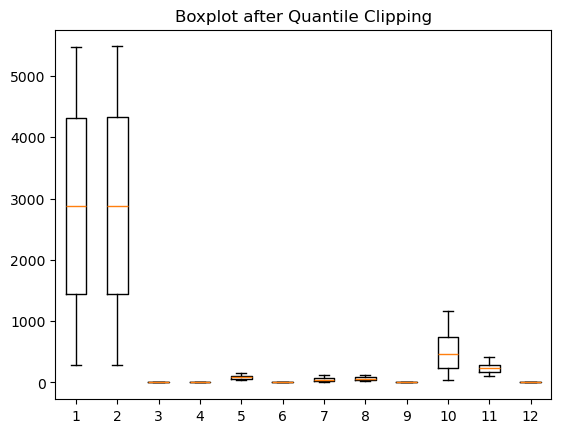

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("mutagenicity_kNN.csv")


print(data.isnull().sum())

# Dropping unnecessary columns from data
selected_data = data.drop(columns=['CAS', 'SMILES', 'Status'])

# Conversion of non-numeric columns to numeric
selected_data = selected_data.apply(pd.to_numeric, errors='coerce')


selected_data = selected_data.dropna() 

lower_bound = selected_data.quantile(0.05)
upper_bound = selected_data.quantile(0.95)
processed_data = selected_data.clip(lower=lower_bound, upper=upper_bound, axis=1)

# Boxplot visualization
plt.boxplot(processed_data)
plt.title("Boxplot after Quantile Clipping")
plt.show()


In [8]:
print(processed_data.describe())

        Unnamed: 0           Id  Experimental value  Predicted value  \
count  5758.000000  5758.000000         5758.000000      5758.000000   
mean   2880.358631  2884.854463            0.564258         0.574679   
std    1640.314054  1642.846430            0.495897         0.494435   
min     287.850000   288.850000            0.000000         0.000000   
25%    1439.250000  1441.250000            0.000000         0.000000   
50%    2880.500000  2884.500000            1.000000         1.000000   
75%    4321.750000  4328.750000            1.000000         1.000000   
max    5473.150000  5481.150000            1.000000         1.000000   

       NumValenceElectrons          qed         TPSA        MolMR  \
count          5758.000000  5758.000000  5758.000000  5758.000000   
mean             84.727683     0.515052    51.325993    63.685405   
std              32.125722     0.155028    34.153558    24.981700   
min              36.000000     0.231107     0.000000    24.678260   
25%   

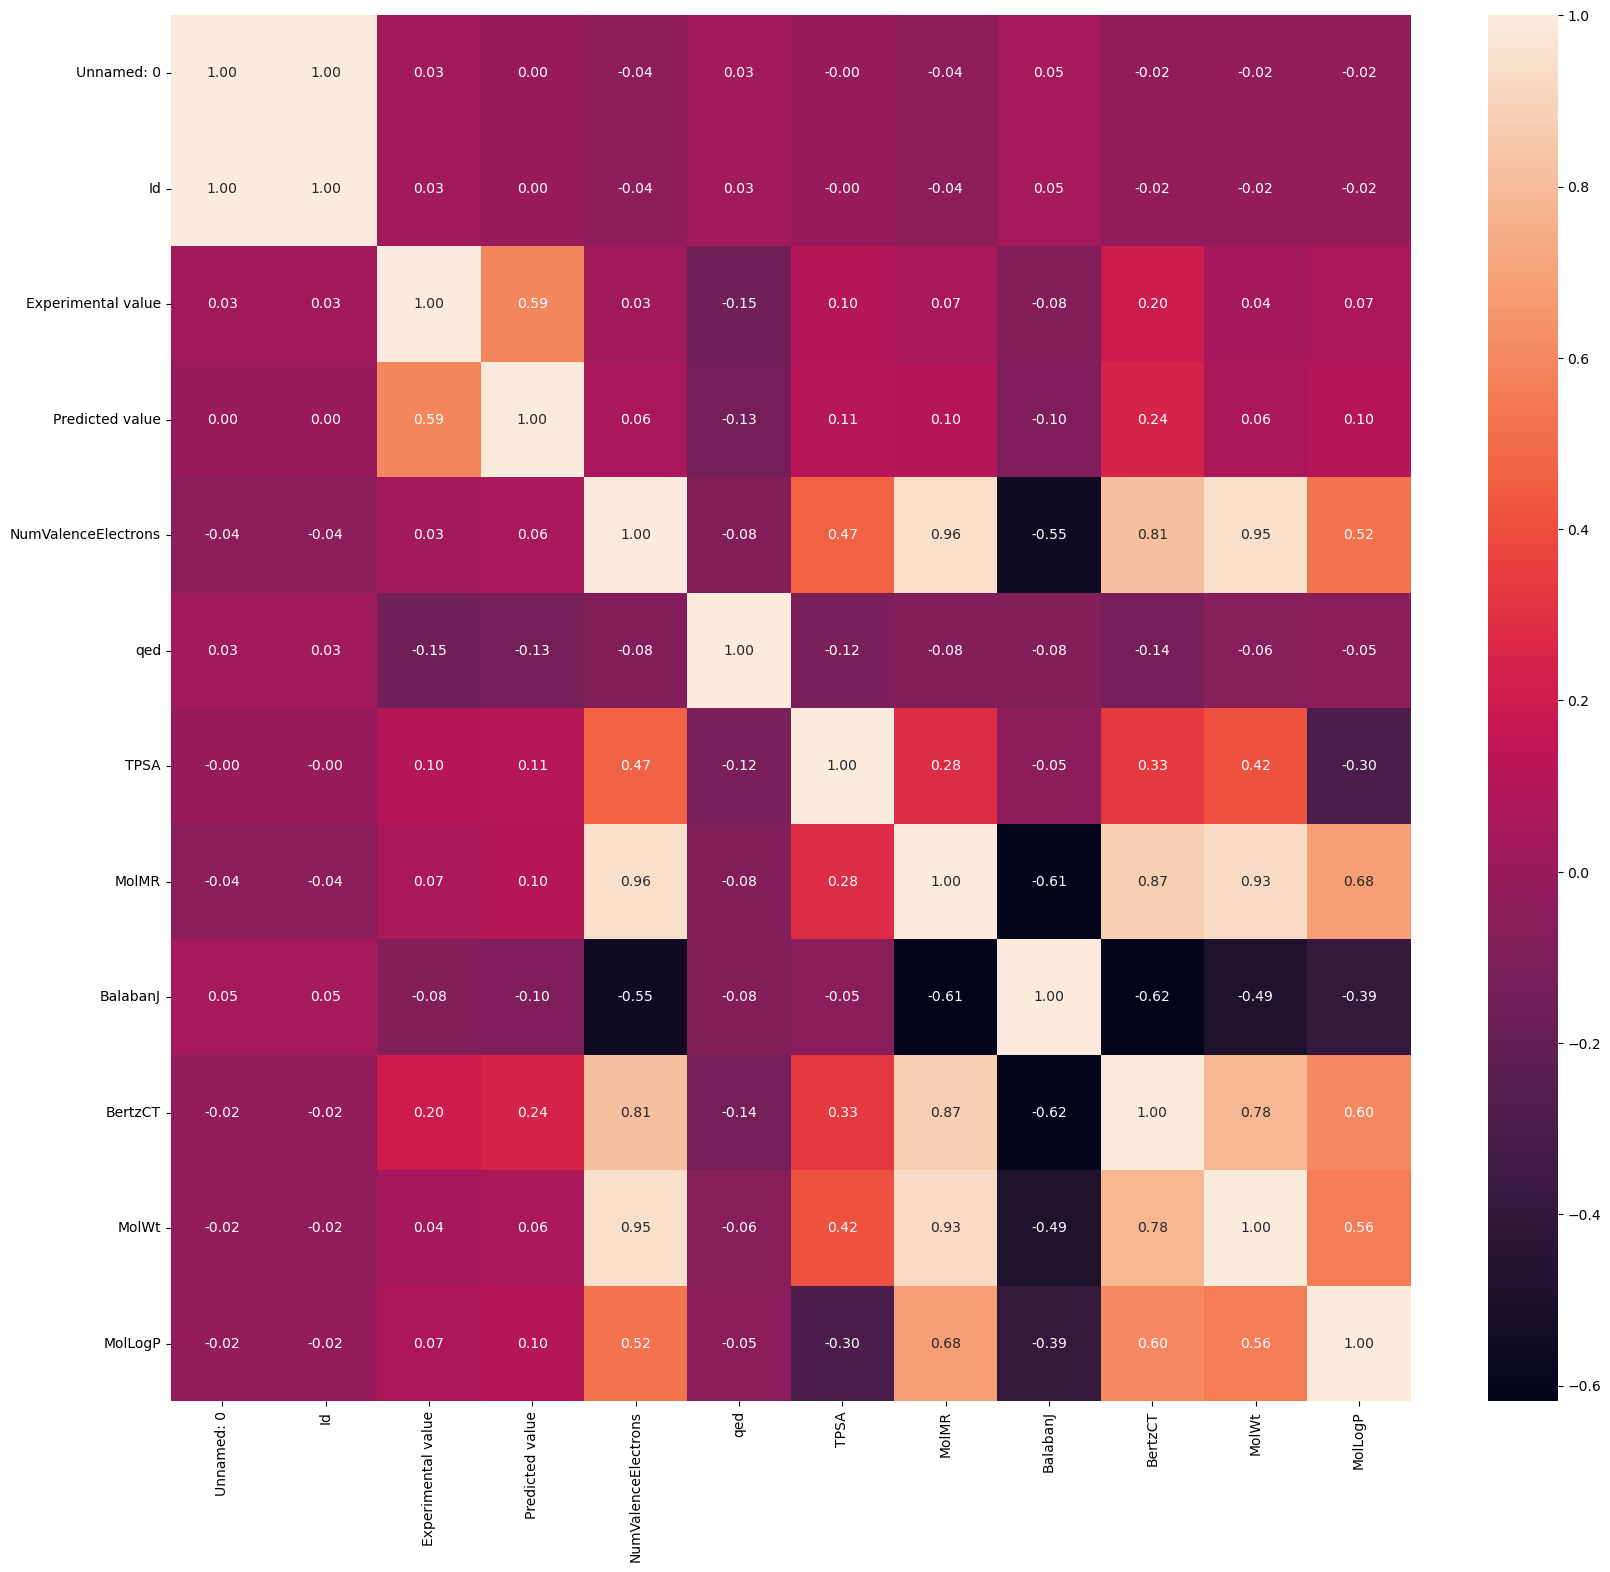

In [9]:
# Visualizing the correlation again 
plt.figure(figsize=(20,18))
sns.heatmap(processed_data.corr(), annot=True, fmt=".2f")
plt.show()

In [10]:
# Splitting features and target variable
X = processed_data.drop(columns=['Id', 'Experimental value', 'NumValenceElectrons', 'qed'])
y = processed_data['Experimental value']

In [11]:
from sklearn.model_selection import train_test_split

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
X_train, X_test, y_train, y_test = map(np.array, [X_train, X_test, y_train, y_test])

In [12]:
# Adding bias term for models requiring an intercept
X_train_bias = np.c_[np.ones(X_train.shape[0]), X_train]
X_test_bias = np.c_[np.ones(X_test.shape[0]), X_test]
print(f"Training Data Shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing Data Shape: {X_test.shape}, Labels: {y_test.shape}")


Training Data Shape: (4606, 8), Labels: (4606,)
Testing Data Shape: (1152, 8), Labels: (1152,)


In [13]:
from sklearn.preprocessing import StandardScaler

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
from sklearn.neighbors import KNeighborsClassifier

# Training KNN model
knn = KNeighborsClassifier(n_neighbors=9, weights='distance', metric='euclidean')
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=9, weights='distance')

In [15]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")

Cross-validation scores: [0.79501085 0.79261672 0.77741585 0.77850163 0.79044517]
Mean cross-validation accuracy: 0.7868


In [16]:
# Making predictions
y_pred = knn.predict(X_test_scaled)

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Evaluating model performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"KNN Accuracy: {accuracy:.4f}")
print(f"KNN F1 Score: {f1:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred), "\n")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

KNN Accuracy: 0.8003
KNN F1 Score: 0.8263

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77       501
           1       0.81      0.84      0.83       651

    accuracy                           0.80      1152
   macro avg       0.80      0.79      0.80      1152
weighted avg       0.80      0.80      0.80      1152
 

Confusion Matrix:
 [[375 126]
 [104 547]]


In [18]:
# Extracting probabilities
y_pred_proba = knn.predict_proba(X_test)
positive_class_proba = y_pred_proba[:, 1]

In [22]:
print(f"y_pred_probability: {y_pred_proba}")
print(f"positive_class_probability: {positive_class_proba}")

y_pred_probability: [[0.11110783 0.88889217]
 [0.         1.        ]
 [0.         1.        ]
 ...
 [0.11111043 0.88888957]
 [0.         1.        ]
 [0.11111071 0.88888929]]
positive_class_probability: [0.88889217 1.         1.         ... 0.88888957 1.         0.88888929]
